In [ ]:
!unzip "/content/oil-spill-detection-main.zip"

Archive:  /content/oil-spill-detection-main.zip
4dec63e30fad1a4843b9470dd4b495cd21164519
replace oil-spill-detection-main/Part 1 - Oil spill with CNN.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unrar "/content/oil-spill-detection-main/oil-spill-detection-main/train.rar"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal

Usage:     unrar <command> -<switch 1> -<switch N> <archive> <files...>
               <@listfiles...> <path_to_extract\>

<Commands>
  e             Extract files without archived paths
  l[t[a],b]     List archive contents [technical[all], bare]
  p             Print file to stdout
  t             Test archive files
  v[t[a],b]     Verbosely list archive contents [technical[all],bare]
  x             Extract files with full path

<Switches>
  -             Stop switches scanning
  @[+]          Disable [enable] file lists
  ad            Append archive name to destination path
  ag[format]    Generate archive name using the current date
  ai            Ignore file attributes
  ap<path>      Set path inside archive
  c-            Disable comments show
  cfg-          Disable read configuration
  cl            Convert names to lower case
  cu            Convert names to upper case
  dh            Open shared fi

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.0 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("/content/oil-spill-detection-main/train.rar", outdir="/content/oil-spill-detection-main")

patool: Extracting /content/oil-spill-detection-main/train.rar ...
patool: running /usr/bin/unrar x -- /content/oil-spill-detection-main/train.rar
patool:     with cwd='/content/oil-spill-detection-main'


PatoolError: ignored

In [ ]:
patoolib.extract_archive("/content/oil-spill-detection-main/test.rar", outdir="/content/oil-spill-detection-main")

patool: Extracting /content/oil-spill-detection-main/test.rar ...
patool: running /usr/bin/unrar x -- /content/oil-spill-detection-main/test.rar
patool:     with cwd='/content/oil-spill-detection-main'


PatoolError: ignored

In [ ]:
!pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-2.1.7-py2.py3-none-any.whl size=27983 sha256=bcc4cc89f921e4a09fe1c2044cc54ab9225c5d6ad65116864b8fa3310898c03e
  Stored in directory: /root/.cache/pip/wheels/c1/4b/bc/51a7f7e9d7f3f8914a52cf26f9372216bbf75fa70a827d1d78
Successfully built jcopdl


In [ ]:
import jcopdl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim


In [ ]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [ ]:
bs = 16
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale = (0.9, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(240),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/oil-spill-detection-main/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=1)

test_set = datasets.ImageFolder("/content/oil-spill-detection-main/train", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
label2cat = train_set.classes
label2cat

['nospill', 'oilspill']

In [ ]:
from torchvision.models import mobilenet_v2

In [ ]:
mnet = mobilenet_v2(pretrained = True)
for param in mnet.parameters():
    param.requires_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.LogSoftmax()
)

In [ ]:
!pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from jcopdl.callback import Callback, set_config
from jcopdl.utils import set_pytorch_random_state

In [ ]:
!pip install jcopdl==1.1.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from jcopdl.callback import *
class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self,x):
        return self.mnet(x)
    
    def freeze(self):
        for param in mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in mnet.parameters():
            param.requires_grad = True

config = jcopdl.callback.set_config({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

In [ ]:
model = CustomMobilenetV2(len(train_set.classes)).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience = 5, outdir="model")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.5367 | Test_cost  = 7.7235 | Train_score = 0.7665 | Test_score = 0.5228 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.4122 | Test_cost  = 0.2544 | Train_score = 0.8680 | Test_score = 0.8985 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2640 | Test_cost  = 0.2384 | Train_score = 0.9086 | Test_score = 0.9137 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2192 | Test_cost  = 0.0997 | Train_score = 0.9137 | Test_score = 0.9594 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f40d095f5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f40d095f5e0>
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1966 | Test_cost  = 0.1953 | Train_score = 0.9442 | Test_score = 0.8985 |
==> EarlyStop patience =  1 | Best test_score: 0.9594


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2314 | Test_cost  = 0.1205 | Train_score = 0.9289 | Test_score = 0.9442 |
==> EarlyStop patience =  2 | Best test_score: 0.9594


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2900 | Test_cost  = 0.0978 | Train_score = 0.8832 | Test_score = 0.9543 |
==> EarlyStop patience =  3 | Best test_score: 0.9594


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2237 | Test_cost  = 0.2298 | Train_score = 0.9086 | Test_score = 0.8985 |
==> EarlyStop patience =  4 | Best test_score: 0.9594


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1279 | Test_cost  = 0.0754 | Train_score = 0.9492 | Test_score = 0.9797 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.2155 | Test_cost  = 0.0419 | Train_score = 0.9391 | Test_score = 0.9797 |
==> EarlyStop patience =  1 | Best test_score: 0.9797


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0927 | Test_cost  = 0.0575 | Train_score = 0.9746 | Test_score = 0.9848 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0986 | Test_cost  = 0.0277 | Train_score = 0.9645 | Test_score = 1.0000 |


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1897 | Test_cost  = 0.1407 | Train_score = 0.9137 | Test_score = 0.9239 |
==> EarlyStop patience =  1 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1307 | Test_cost  = 0.0441 | Train_score = 0.9645 | Test_score = 0.9746 |
==> EarlyStop patience =  2 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0676 | Test_cost  = 0.0331 | Train_score = 0.9797 | Test_score = 0.9848 |
==> EarlyStop patience =  3 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1848 | Test_cost  = 0.0493 | Train_score = 0.9594 | Test_score = 0.9898 |
==> EarlyStop patience =  4 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1241 | Test_cost  = 0.1131 | Train_score = 0.9543 | Test_score = 0.9543 |
==> EarlyStop patience =  5 | Best test_score: 1.0000
==> Execute Early Stopping at epoch: 17 | Best test_score: 1.0000
==> Best model is saved at model


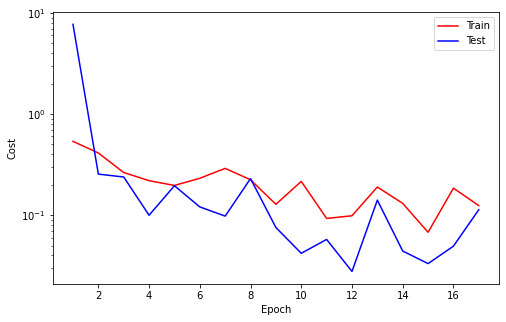

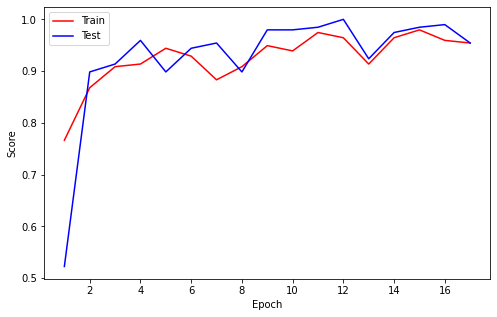

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    callback.log(train_cost, test_cost, train_score, test_score)

    callback.save_checkpoint()

    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model (feature)
    preds = output

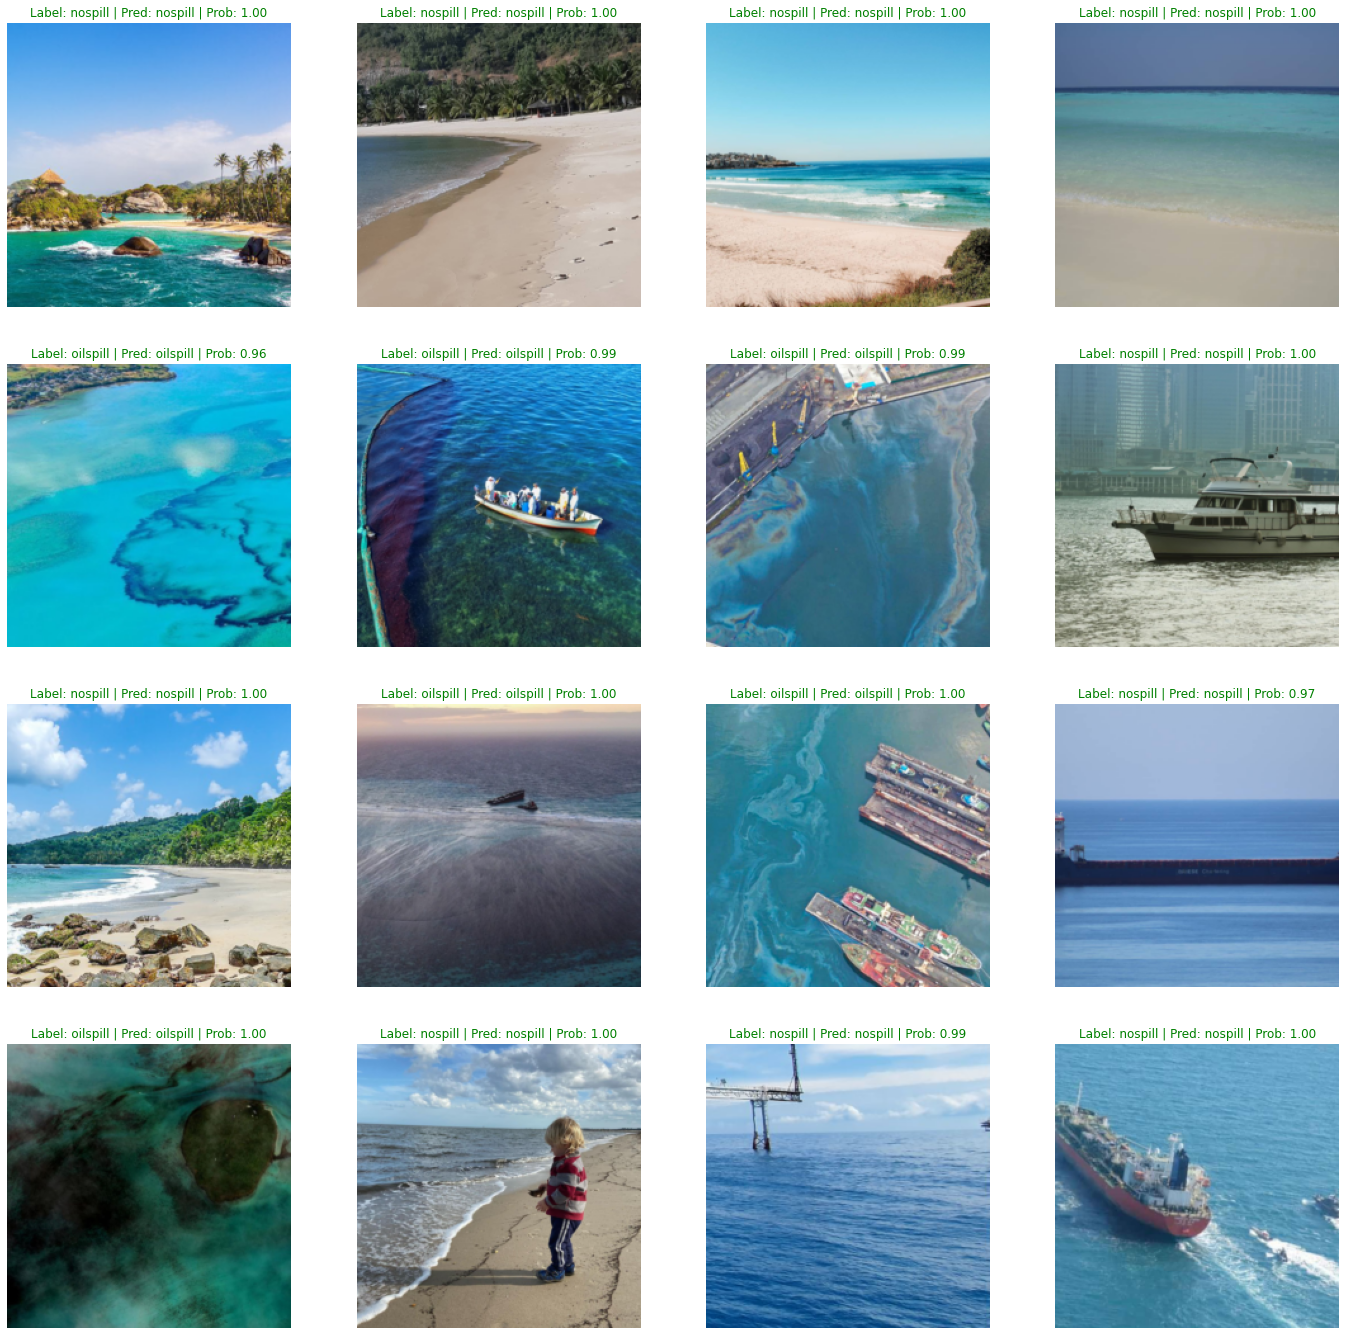

In [ ]:
fig, axes = plt.subplots(4,4, figsize = (24,24))

for img, label, pred, ax in zip (feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    font = {"color": 'r'} if label != pred.argmax(0) else {"color":'g'}
    label, pred, prob = label2cat [label.item()], label2cat[pred.cpu().argmax(0).item()], "{:.2f}".format(max(np.exp(pred.cpu())).item())
    ax.set_title(f"Label: {label} | Pred: {pred} | Prob: {prob}", fontdict= font)
    ax.axis("off")

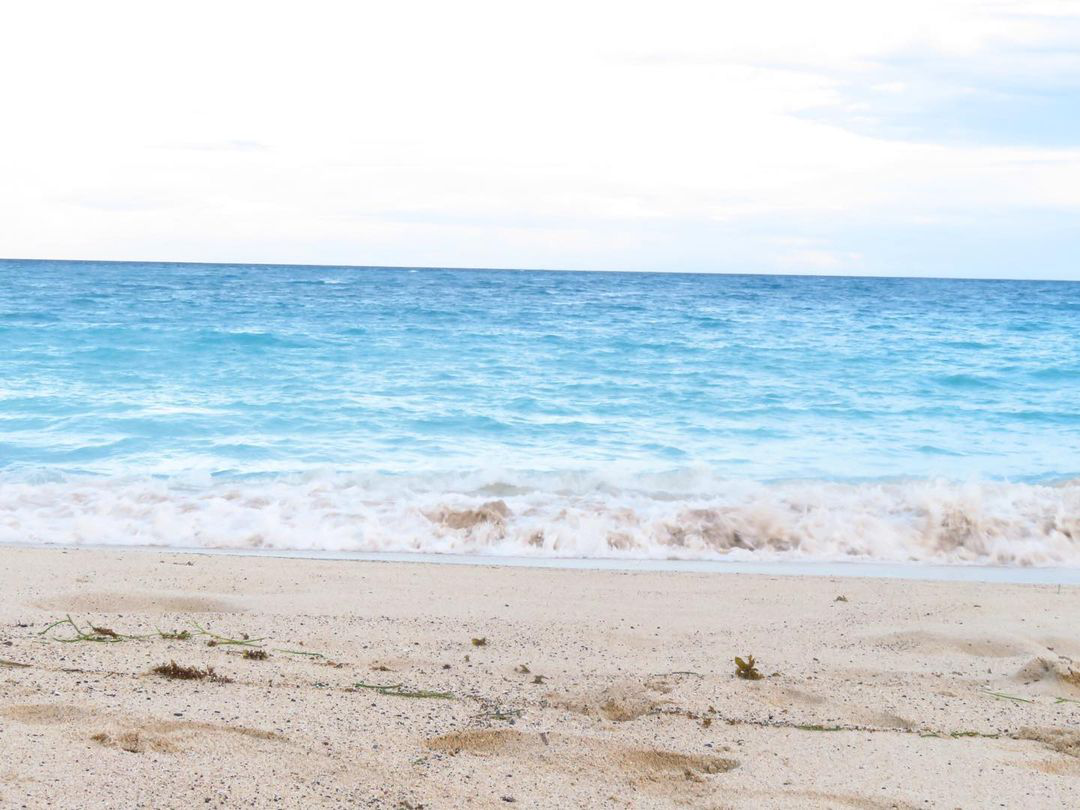

In [ ]:
from PIL import Image
def image_loader(image_name):
    image = Image.open(image_name)
    image = test_transform(image).float()
    image = image.unsqueeze(0)  
    return image
Image.open("/content/oil-spill-detection-main/test/nospill/137649264_859471474884124_2199984751562855074_n.jpg")

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(image_loader("/content/oil-spill-detection-main/test/nospill/137649264_859471474884124_2199984751562855074_n.jpg").to(device))
    print(f"there is %s with probability %s" %(label2cat[output.cpu().argmax(1).item()], "{:.2f}".format(max(np.exp(output.cpu())[0]))))

there is nospill with probability 1.00


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
model.unfreeze()
optimizer = optim.AdamW (model.parameters(), lr= 1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.0437 | Test_cost  = 0.0221 | Train_score = 0.9848 | Test_score = 0.9949 |
==> EarlyStop patience =  1 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.0518 | Test_cost  = 0.0145 | Train_score = 0.9797 | Test_score = 1.0000 |
==> EarlyStop patience =  2 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.0665 | Test_cost  = 0.0130 | Train_score = 0.9797 | Test_score = 1.0000 |


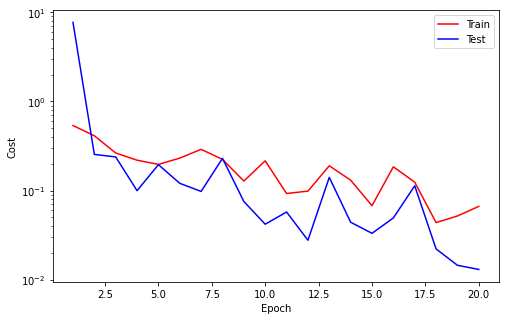

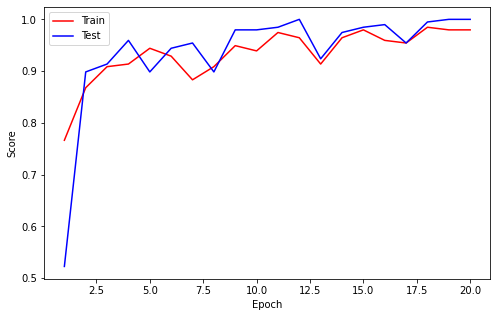

==> EarlyStop patience =  3 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.0265 | Test_cost  = 0.0123 | Train_score = 0.9949 | Test_score = 1.0000 |
==> EarlyStop patience =  4 | Best test_score: 1.0000


Train:   0%|          | 0/13 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.0586 | Test_cost  = 0.0130 | Train_score = 0.9898 | Test_score = 1.0000 |
==> EarlyStop patience =  5 | Best test_score: 1.0000
==> Execute Early Stopping at epoch: 22 | Best test_score: 1.0000
==> Best model is saved at model


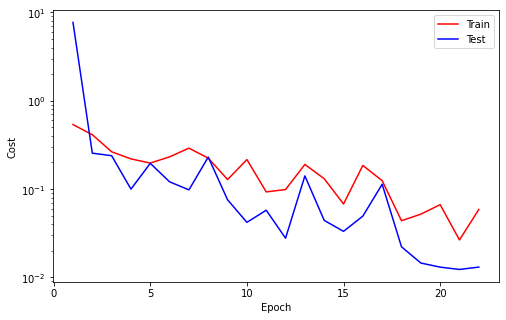

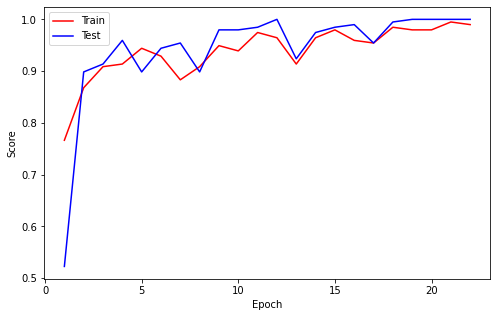

In [ ]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break